---
# Demo for the Usage of GenCAT Workbench
---

We show 
1. how users can generate graphs similar to an input graph, 
2. how users can configure and change the parameters of GenCAT.


In [6]:
# install packages for GenCAT
!pip install powerlaw
!pip install jgraph

# for running GCN and GAT. Note that you do not execute this install for H2GCN since it runs on tensorflow>=2.0 which is pre-installed on Colab.
!pip install tensorflow-gpu==1.15.5

     |████████████████████████████████| 411.0 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 37.3 MB/s 
     |████████████████████████████████| 20.1 MB 265 kB/s 
     |████████████████████████████████| 2.9 MB 41.8 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 503 kB 25.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f74c4394047d0b171e4819fd4b0b5837ad7d2c4cbcc952036e614ec5d89e6494
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tenso

In [3]:
drive_root = "/content/drive/My Drive/Colab Notebooks/GenCAT/"
drive_root_command = "/content/drive/MyDrive/Colab\ Notebooks/GenCAT/"

import sys
import os.path
sys.path.append(os.path.join(drive_root))
import numpy as np
import time
import pandas as pd

import gencat
from func import cpm_cpd_plot, att_plot, loadData, _load_data, save_graph, compute_graph_statistics, feature_extraction

In [4]:
dataset_str = "cora" # select data that you want to use

def GenCAT_graph_reproduction(dataset_str="cora"):
  adj, features, labels = _load_data(dataset_str) # load dataset

  print("######### Statistics of Input Dataset #########")
  print("######################################\n")
  # print basic statistics of the graph
  print("The number of nodes: " + str(adj.shape[0]))
  print("The number of edges: " + str(int(adj.sum()/2)))
  print("The number of attributes: " + str(features.shape[1]))

  _ = cpm_cpd_plot(adj, labels,cpd=False)
  # stats = compute_graph_statistics(adj, Z_obs=np.identity(max(labels)+1)[labels])
  # display(pd.DataFrame(stats.values(), index=stats.keys()))

  print("\n\n\n#########################################")
  print("### GenCAT is generating graphs similar to the input ###")
  print("#########################################\n\n")
  M,D,class_size,H,theta = feature_extraction(adj,features,labels) # extract features from the dataset

  S,X,Label = gencat.gencat(M,D,H,class_size=class_size,theta=theta,att_type="Bernoulli")

  print("######### Statistics of Generated Graph #########")
  print("########################################\n")
  # print basic statistics of the graph
  print("The number of nodes: " + str(S.shape[0]))
  print("The number of edges: " + str(int(S.sum()/2)))
  print("The number of attributes: " + str(features.shape[1]))

  _ = cpm_cpd_plot(S,Label,cpd=False)
  # stats = compute_graph_statistics(S, Z_obs=np.identity(max(Label)+1)[Label])
  # display(pd.DataFrame(stats.values(), index=stats.keys()))

# Graph Reproduction Using Graph Features and Class Features by GenCAT


*   Graph features
  * node degree distribution
  * attribute distribution
*   Class features
  * class preference mean : $M$
  * class preference deviation : $D$
  * class size distribution : $\rho$
  * attribute correlation : $H$

Class features are extracted from an adjacency matrix, an attribute matrix, and class labels. 

---
## We extract the features from an input dataset and generate a graph from those features by GenCAT. 

######### Statistics of Input Dataset #########
######################################

The number of nodes: 2708
The number of edges: 5278
The number of attributes: 1433


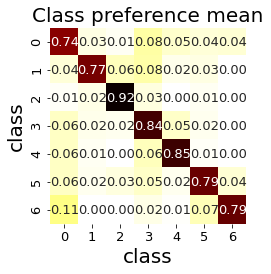




#########################################
### GenCAT is generating graphs similar to the input ###
#########################################


######### Statistics of Generated Graph #########
########################################

The number of nodes: 2708
The number of edges: 5265
The number of attributes: 1433


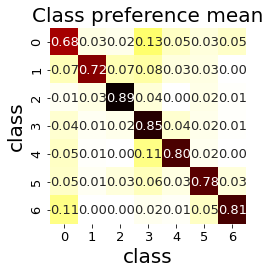

In [5]:
GenCAT_graph_reproduction(dataset_str="cora") # users can choose a dataset from ['cora', 'citeseer', 'pubmed']

---
# Configure the parameters of GenCAT
---

## In this demo, we show that GenCAT can generate graphs with various class connection properties from homophily to heterophily. 

e.g., we set the diagonal elements of $M$ to $0.1$ smaller, iteratively. 

In [ ]:
dataset_str = "cora" # users can choose a dataset from ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels) # extract features from an input dataset

In [ ]:
for x in range(9):
  diag = 0
  for i in range(M.shape[0]):
    diag+= max(M[i][i]-0.1*x, 0)
  print(diag/M.shape[0])

0.8128969148816033
0.7128969148816031
0.6128969148816031
0.5128969148816032
0.4128969148816032
0.31289691488160315
0.2128969148816031
0.11289691488160311
0.02918979010732021


In [ ]:
def config_class_preference_mean(M,D,x=1):
  import copy
  k = M.shape[0] # number of classes
  M_ = copy.deepcopy(M)
  D_ = copy.deepcopy(D)
  if x != 0:
    for i in range(k): # for each diagonal element
  # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          M_[i][j] -= 0.1 * x
        else:
          M_[i][j] += (0.1 * x) / (k-1)
      M_[M_<0] = 0
    for i in range(k):
    # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]+0.1*x))
        else:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]- (0.1)/(k-1)))
    for i in range(k):
      M_[i] = M_[i] / sum(M_[i])    
    D_[D_<=0] = 0
  return M_, D_

def GraphGenerate_VariousConnectionProperties(dataset_str="cora", step=1):
  adj, features, labels = _load_data(dataset_str) # load dataset
  M,D,class_size,H,theta = feature_extraction(adj,features,labels) # extract features from an input dataset
  for x in range(step):
    if x == 0:
      print("######### Current step: directly use the features from "+dataset_str+" #########")
      print("#####################################################\n")
    else:
      print("\n\n#####################################")
      print("######### Current step: M[l][l] - 0." + str(x) + " #########")
      print("#####################################\n")
    M_, D_ = config_class_preference_mean(M,D,x=x)
    S,X,Label = gencat.gencat(M_,D_,H,class_size=class_size,theta=theta,att_type="Bernoulli")
    _ = cpm_cpd_plot(S,Label,cpm=True,cpd=False)
    # stats = compute_graph_statistics(S, Z_obs=np.identity(max(Label)+1)[Label])
    # display(pd.DataFrame(stats.values(), index=stats.keys()))

######### Current step: directly use the features from cora #########
#####################################################



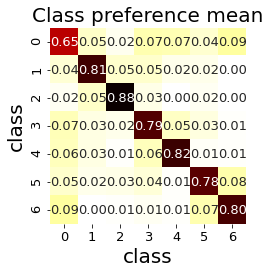



#####################################
######### Current step: M[l][l] - 0.1 #########
#####################################



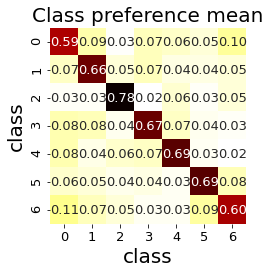



#####################################
######### Current step: M[l][l] - 0.2 #########
#####################################



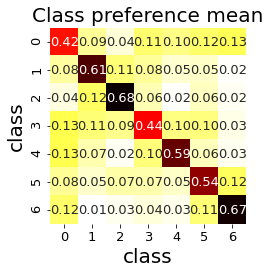



#####################################
######### Current step: M[l][l] - 0.3 #########
#####################################



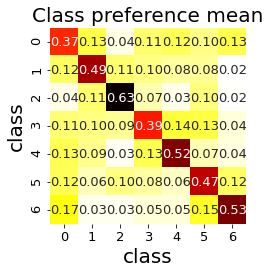



#####################################
######### Current step: M[l][l] - 0.4 #########
#####################################



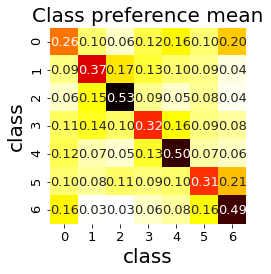



#####################################
######### Current step: M[l][l] - 0.5 #########
#####################################



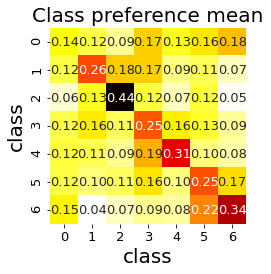



#####################################
######### Current step: M[l][l] - 0.6 #########
#####################################



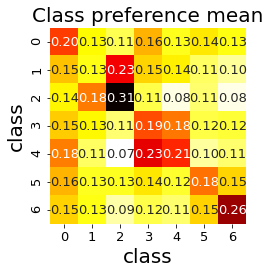



#####################################
######### Current step: M[l][l] - 0.7 #########
#####################################



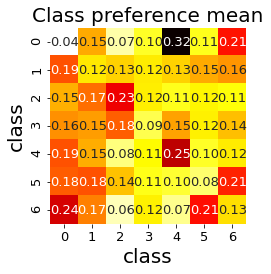



#####################################
######### Current step: M[l][l] - 0.8 #########
#####################################



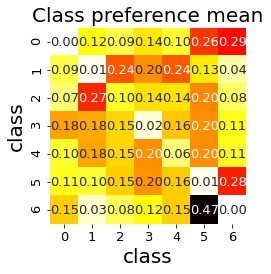

In [ ]:
GraphGenerate_VariousConnectionProperties(dataset_str="cora", step=9) # users can choose a dataset from ['cora', 'citeseer', 'pubmed']

In [ ]:
def print_statistics(adj, features, labels, data=""):
  if data == "load":
    print("\n\n#############################")
    print("#########   loaded data   #########")
    print("#############################")
  elif data == "generated":
    print("\n\n#############################")
    print("######### generated data ########")
    print("#############################")
  print("The number of nodes: " + str(adj.shape[0]))
  print("The number of edges: " + str(int(adj.sum()/2)))
  print("The number of attributes: " + str(features.shape[1]))
  _ = cpm_cpd_plot(adj,labels,cpm=True,cpd=False)

def config_diagonal(M,D,x=1):
  import copy
  k = M.shape[0] # number of classes
  M_ = copy.deepcopy(M)
  D_ = copy.deepcopy(D)
  if x != 0:
    for i in range(k): # for each diagonal element
  # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          M_[i][j] -= 0.1 * x
        else:
          M_[i][j] += (0.1 * x) / (k-1)
      M_[M_<0] = 0
    for i in range(k):
    # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]+0.1*x))
        else:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]- (0.1)/(k-1)))
    for i in range(k):
      M_[i] = M_[i] / sum(M_[i])    
    D_[D_<=0] = 0
  return M_, D_

# Store the generated graph

Users can evaluate their graph analysis methods by using stored graphs as benchmark data. 



#############################
#########   loaded data   #########
#############################
The number of nodes: 2708
The number of edges: 5278
The number of attributes: 1433


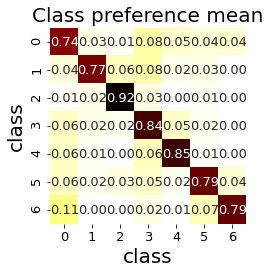



#############################
######### generated data ########
#############################
The number of nodes: 2708
The number of edges: 5270
The number of attributes: 1433


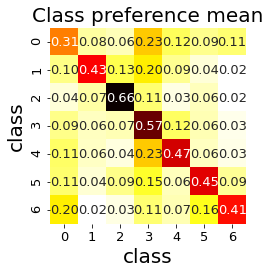

In [ ]:
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
print_statistics(adj,features,labels,data="load")
# extract features from an input dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)


## configure M, D, class_size, H, node_degree. ##
x = 3 # for example, we show the case of x=3
M_config, D_config = config_diagonal(M, D, x) # M_config[l,l] = M[l,l] - 0.1*x


# graph generation from extracted and configured parameters
S,X,Label = gencat.gencat(M_config,D_config,H,class_size=class_size,theta=node_degree)
print_statistics(S,X,Label,data="generated")

# save the generated graph
save_graph(S,X,Label,dataset_str="GenCAT_"+dataset_str)